# Corona prepping using Finnish data regression using a categorical boosting forest algorithm

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix,
                     summary_performance_metrics_classification)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold
# from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn.model_selection import KFold

In [5]:
import pingouin as pg

import neuropy_correlation as np_corr

/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
# from sklearn import tree
# import graphviz

In [7]:
from catboost import CatBoostRegressor, Pool

In [8]:
# import xgboost
import shap
shap.initjs()

In [9]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [10]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [11]:
df = pd.read_csv("data/shield_gjames_21-06-10.csv").drop("id", axis=1)

In [12]:
df.head()

demographic_gender demographic_age  demographic_4_areas  \
0                   1           50-59                    1   
1                   2           30-39                    2   
2                   1           18-29                    1   
3                   1             60+                    1   
4                   1             60+                    2   

   demographic_8_areas  behaviour_indoors_nonhouseholders  \
0                    2                                  5   
1                    6                                  5   
2                    2                                  3   
3                    2                                  4   
4                    7                                  5   

   behaviour_close_contact  behaviour_quarantined  behaviour_unmasked  \
0                        4                      2                   5   
1                        4                      2                   5   
2                        2                      2                   2   
3                        3                      2                   2   
4                        4                      2                   4   

   mask_wearing_cloth_mask  mask_wearing_disposable_mask  ...  \
0                        0                             1  ...   
1                        1                             1  ...   
2                        0                             1  ...   
3                        0                             0  ...   
4                        0                             1  ...   

   sdt_motivation_introjected_3  attention_check  \
0                             2                2   
1                             7                1   
2                             3                1   
3                             5                2   
4                             6                1   

   vaccination_status_intention_self  vaccination_status_closeones  \
0                                  1                             1   
1                                  2                             2   
2                                  3                             1   
3                                  1                             2   
4                                  1                             4   

   covid_tested  had_covid  demographic_risk_group  \
0             1          1                       2   
1             3          2                       2   
2             2          5                       2   
3             2          2                       1   
4             3          1                       2   

   needprotection_before_shots  needprotection_after_1_shot  \
0                            1                            2   
1                            1                            2   
2                            1                            1   
3                            2                            2   
4                            1                            1   

   needprotection_after_2_shots  
0                             3  
1                             5  
2                             7  
3                             2  
4                             3  

[5 rows x 92 columns]

In [13]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [14]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [15]:
df.shape

(2272, 73)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [16]:
target_list = ["behaviour_unmasked", "behaviour_indoors_nonhouseholders"]

In [17]:
# Consider the interested group to analyze
# grouping_var = "behaviour_unmasked"#"Q5" 

# Consider only numerical features
features_list = df.drop(target_list, axis=1).columns.tolist()
# features_list = code_df.loc[code_df["Of primary interest as a predictor (i.e. feature)?"]!="no", "Variable name"].values.tolist()
# make sure the target is not included in the features_list
# try:
#     _ = features_list.remove(target_list)
# except:
#     print(f"The grouping variable {grouping_var} was not present in the feature list to remove.")

# df[grouping_var] = df[grouping_var].astype("category")

### Creating a boolean version of the grouping variable

In [18]:
# if grouping_var == "behaviour_unmasked":
#     df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int) #all the answers other than 5 are considered a 1 in the boolean
# elif grouping_var == "demographic_age":
#     df = (df
#           .assign(PT_AGE_bool=lambda x: x["demographic_age"]
#                   .isin(["40-49", "50-59"]) #ages 40 - 59 are considere 1 in the boolean
#                   .astype(int))
#          .loc[df["PT_AGE"] != "60+", :])
# # elif grouping_var == "Q8_3":
# #     df = df.assign(Q8_3_bool=lambda x: x["Q8_3"]
# #                   .isin([1, 4]) #answers 1 and 4 are considered 1 in the boolean
# #                   .astype(int))
# else:
#     raise ValueError(f"The grouping variable {grouping_var} is not currently supported, please choose from Q5, Q8_3 or PT_AGE.")

## EDA on the target
Check the amount of samples in the target

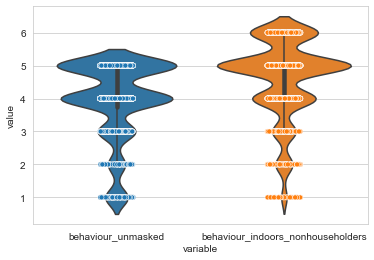

In [19]:
_ = sns.violinplot(data=df[target_list].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[target_list].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [20]:
pd.crosstab(df[target_list[0]], df[target_list[1]])

behaviour_indoors_nonhouseholders   1   2   3    4    5    6
behaviour_unmasked                                          
1                                  23  43  14   20   40   25
2                                   5  15  42   33   21   10
3                                   1  17  43  154   41   21
4                                   1  27  31  161  520   83
5                                   9  22  42   95  356  357

In [21]:
pd.read_csv("data/target_crosstab_pct.csv", 
            sep=";", 
            index_col=0)

Every day (1) 5-6 days (2) 3-4 days (3) 1-2 days (4)  \
Several times a day (6)       100.00%      -75.00%      -50.00%      -25.00%   
Every day (5)                 100.00%      -75.00%      -50.00%      -25.00%   
5-6 days (4)                   75.00%      100.00%      -75.00%      -50.00%   
3-4 days (3)                   50.00%       75.00%      100.00%      -75.00%   
1-2 days (2)                   25.00%       50.00%       75.00%      100.00%   
Not at all (1)                  0.00%        0.00%        0.00%        0.00%   

                        not at all (5)  
Several times a day (6)          0.00%  
Every day (5)                    0.00%  
5-6 days (4)                   -25.00%  
3-4 days (3)                   -50.00%  
1-2 days (2)                   -75.00%  
Not at all (1)             --removed--

In [22]:
def convert_targets_regression(df, feature1, feature2):
    # feature1 == behaviour_unmasked (1,2,3,4,5)
    # feature2 == behaviour_indoors_nonhouseholders (1,2,3,4,5,6)
    return (df[[feature1, feature2]]
#             .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 1), 100)
#             .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 2), 100)
#             .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 3), 100)
#             .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 4), 100)
#             .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 5), 100)
#             .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 6), 100)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 1), 0)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 1), 0)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 1), 0)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 1), 0)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 1), np.nan)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 2), 25)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 2), 50)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 2), 75)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 2), 100)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 2), -75)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 3), 50)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 3), 75)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 3), 100)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 3), -75)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 3), -50)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 4), 75)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 4), 100)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 4), -75)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 4), -50)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 4), -25)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 5), 100)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 5), -75)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 5), -50)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 5), -25)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 5), 0)
            
            .mask(lambda d: (d[feature1] == 1) & (d[feature2] == 6), 100)
            .mask(lambda d: (d[feature1] == 2) & (d[feature2] == 6), -75)
            .mask(lambda d: (d[feature1] == 3) & (d[feature2] == 6), -50)
            .mask(lambda d: (d[feature1] == 4) & (d[feature2] == 6), -25)
            .mask(lambda d: (d[feature1] == 5) & (d[feature2] == 6), 0)
            
           )

In [23]:
# target_df 

In [24]:
target_df = convert_targets_regression(df=df, feature1=target_list[0], feature2=target_list[1]).mean(axis=1) * 0.01

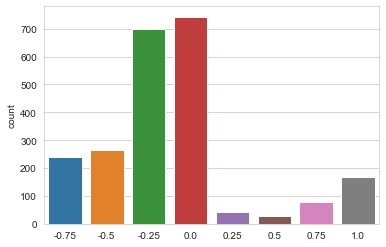

In [25]:
_ = sns.countplot(x=target_df)

## Force all variables to categorical data

In [26]:
df = df.astype("category")

In [27]:
df = (df
 .drop(target_list, axis=1)
 .assign(target = target_df)
      .dropna(axis=0)
)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 0 to 2271
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   demographic_gender                 2263 non-null   category
 1   demographic_age                    2263 non-null   category
 2   demographic_4_areas                2263 non-null   category
 3   demographic_8_areas                2263 non-null   category
 4   behaviour_close_contact            2263 non-null   category
 5   behaviour_quarantined              2263 non-null   category
 6   mask_wearing_cloth_mask            2263 non-null   category
 7   mask_wearing_disposable_mask       2263 non-null   category
 8   mask_wearing_certified_mask        2263 non-null   category
 9   mask_wearing_ffp2                  2263 non-null   category
 10  mask_wearing_vizire                2263 non-null   category
 11  mask_wearing_none                  2263 non

In [29]:
grouping_var = "target"

In [30]:
print(df[grouping_var].value_counts())
# print(df[f"{grouping_var}_bool"].value_counts())

 0.00    743
-0.25    698
-0.50    265
-0.75    238
 1.00    168
 0.75     79
 0.25     43
 0.50     29
Name: target, dtype: int64


In [31]:
# _ = sns.countplot(x=df[grouping_var])
# _ = plt.title("Target balance for modelling")
# _ = plt.show()

In [32]:
# _ = sns.countplot(x=df[f"{grouping_var}_bool"])
# _ = plt.title("Target balance for modelling")
# _ = plt.show()

In [33]:
# grouping_var = f"{grouping_var}_bool" #"Q5_bool"
# grouping_var = "PT_AGE_bool" #"Q5_bool"
# grouping_var = "Q5_bool"

In [34]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(30,10))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
#                     palette="Set2"
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 20))
    gini_plot = sns.barplot(data=feature_importance_df#[feature_importance_df["feature_importance"] != 0]
                            , 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    # model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = shap_values[:,:-1]

#     _ = plt.figure(figsize=(7, 10))
    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    # train the model
#     _ = model.fit(X[feature_importance_df.head(2).feature.tolist()], y, cat_features=feature_importance_df.head(2).feature.tolist())
    
#     rmse_plot = None
    
    y_pred = model.predict(X)

    df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(30,8))
    _ = plt.title(f"Catboost Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
    # _ = plt.ylim([(df_test['y_pred'] - df_test[grouping_var]).min(),
    #               (df_test['y_pred'] - df_test[grouping_var]).max()])
    _ = plt.legend()
    _ = plt.show()
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), rmse_plot, feature_importance_df, shap_actual_df

In [35]:
# feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = features_list[2:],
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

In [36]:
# feature_plot_0

In [37]:
# features_list[2:]

In [38]:
# df.filter(regex="sdt").columns.tolist()

In [39]:
# %%capture
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

# feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="40 - 59"
#                                                                                   )

# feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="60+"
#                                                                                   )

# feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="All"
#                                                                                   )

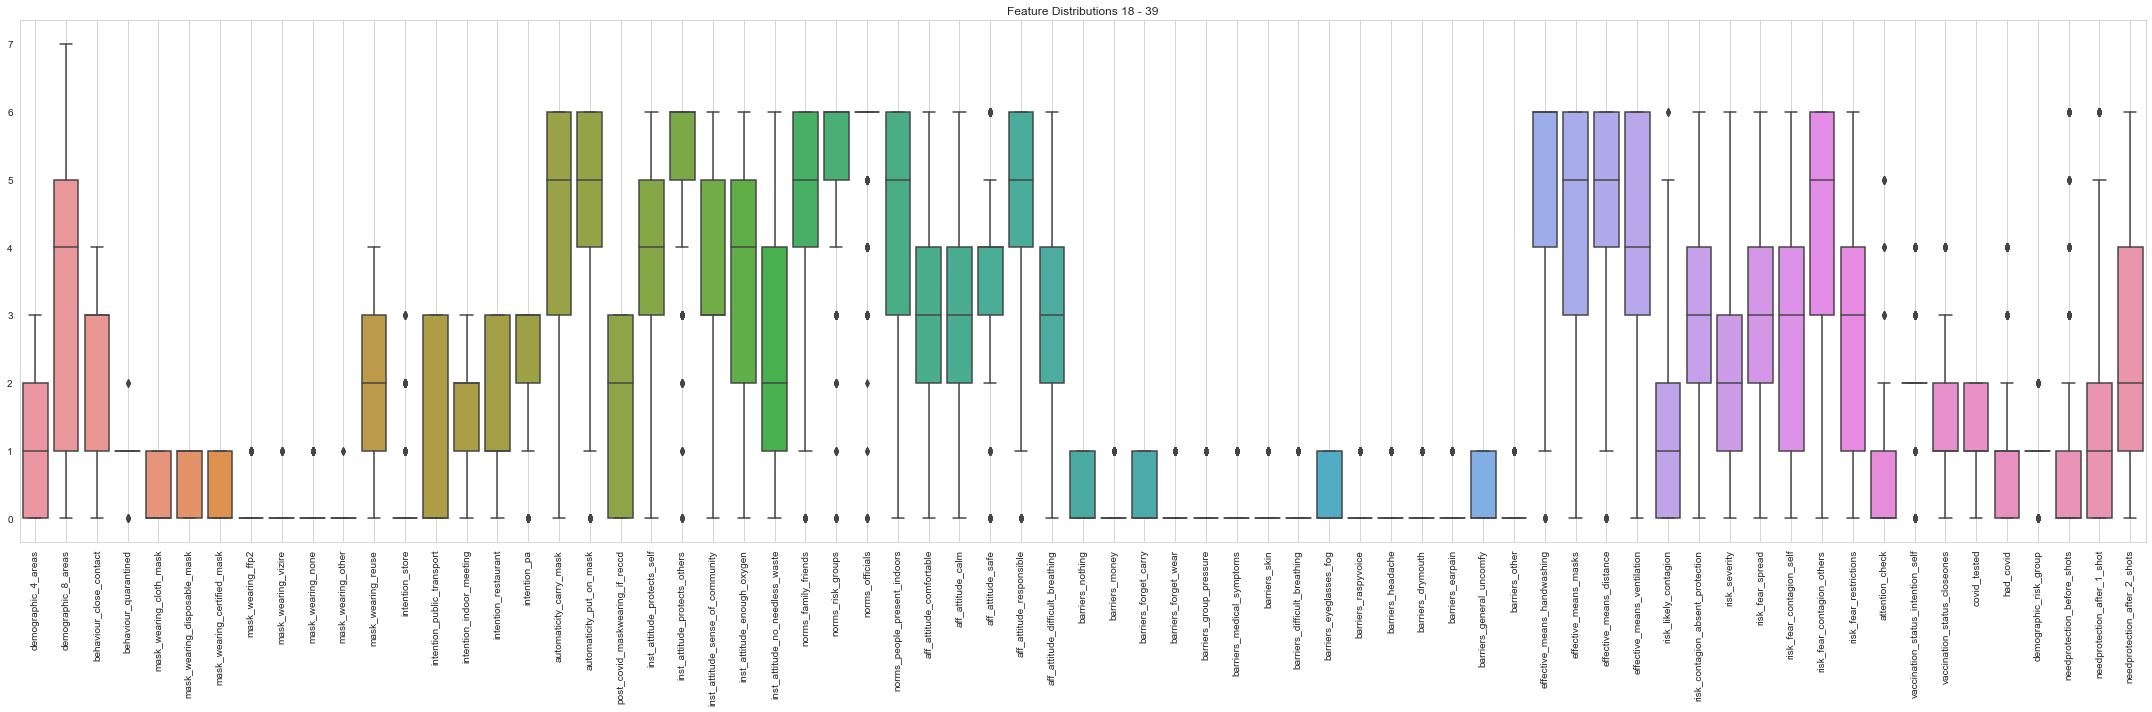

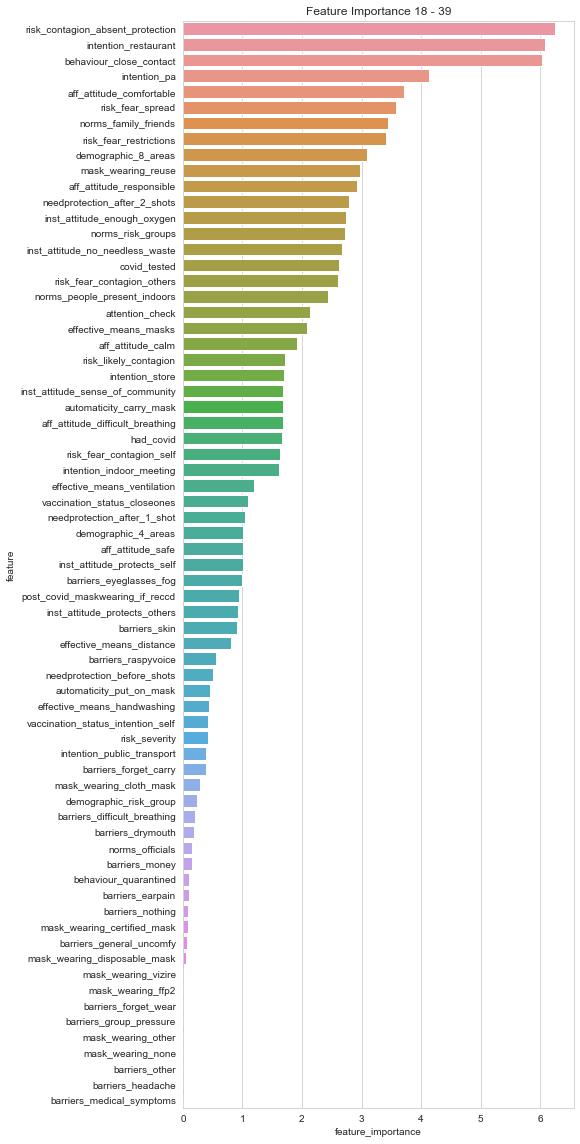

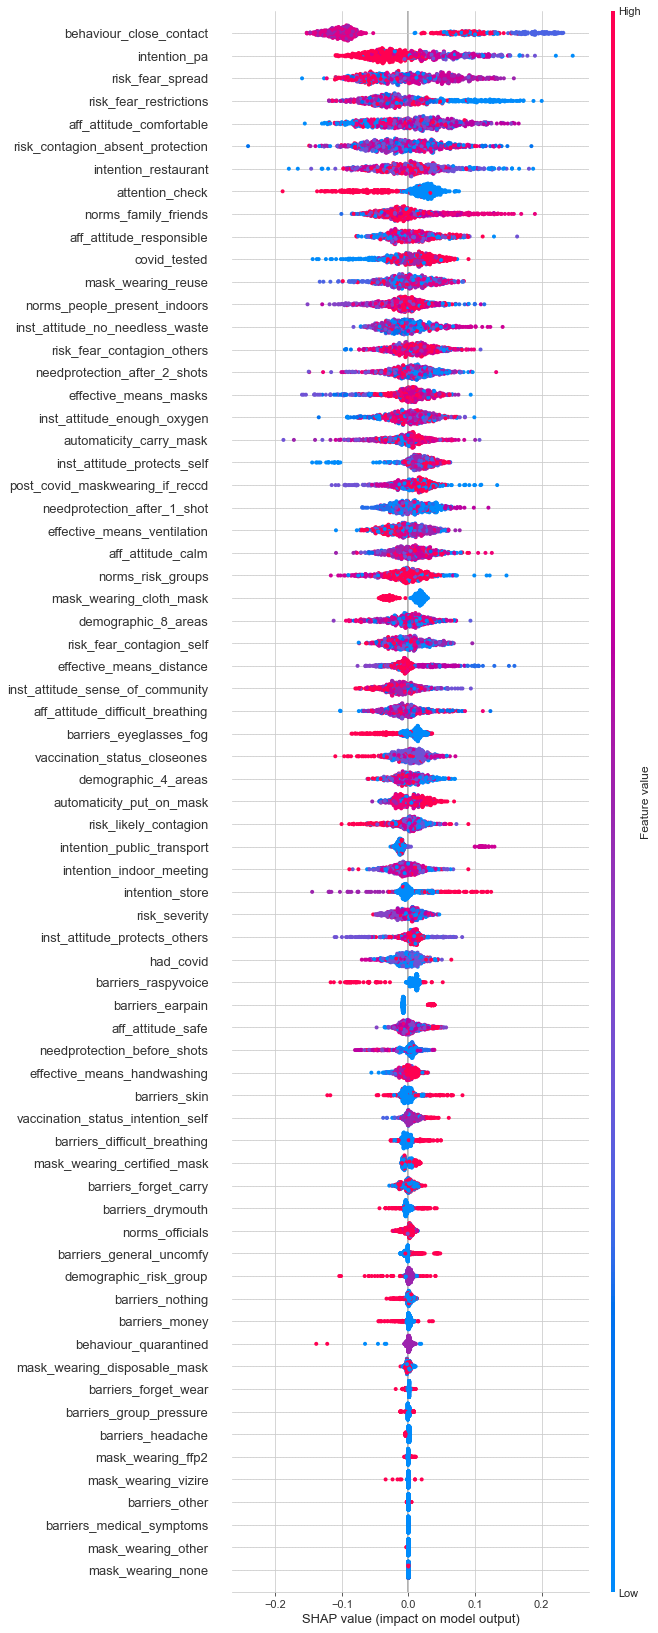

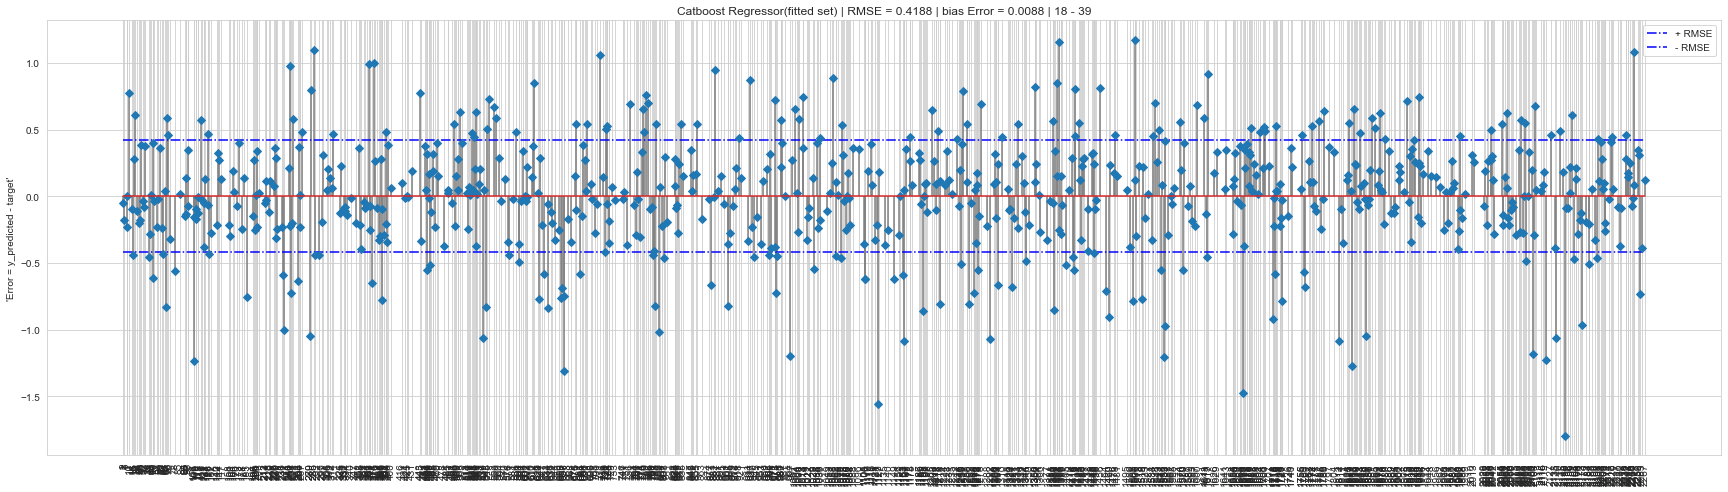

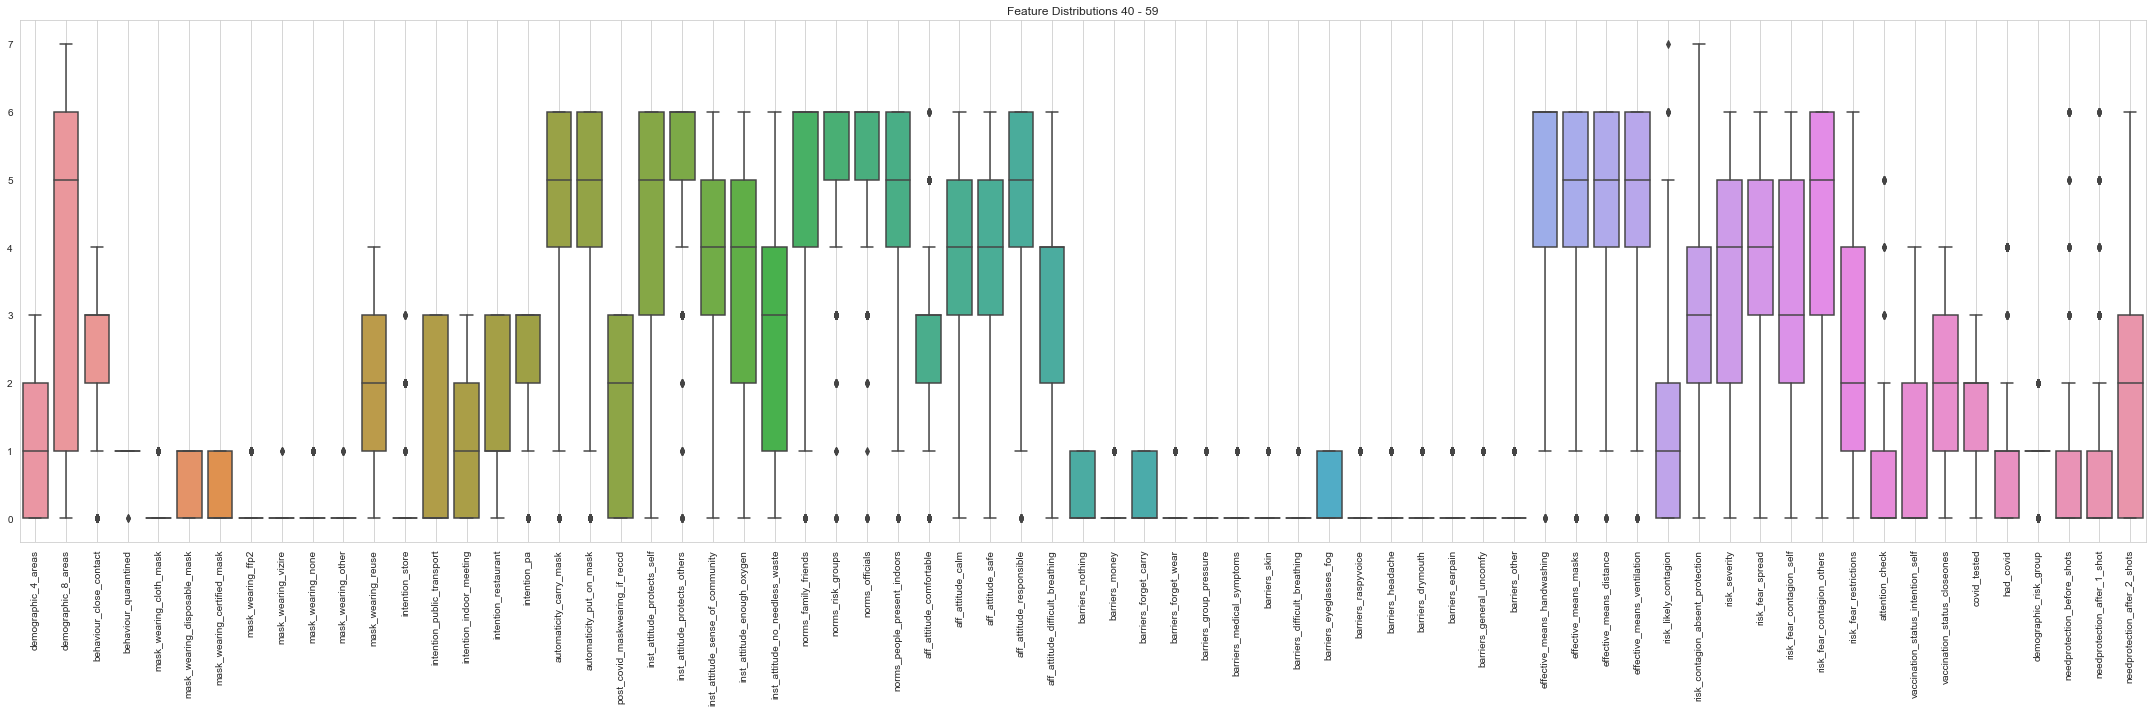

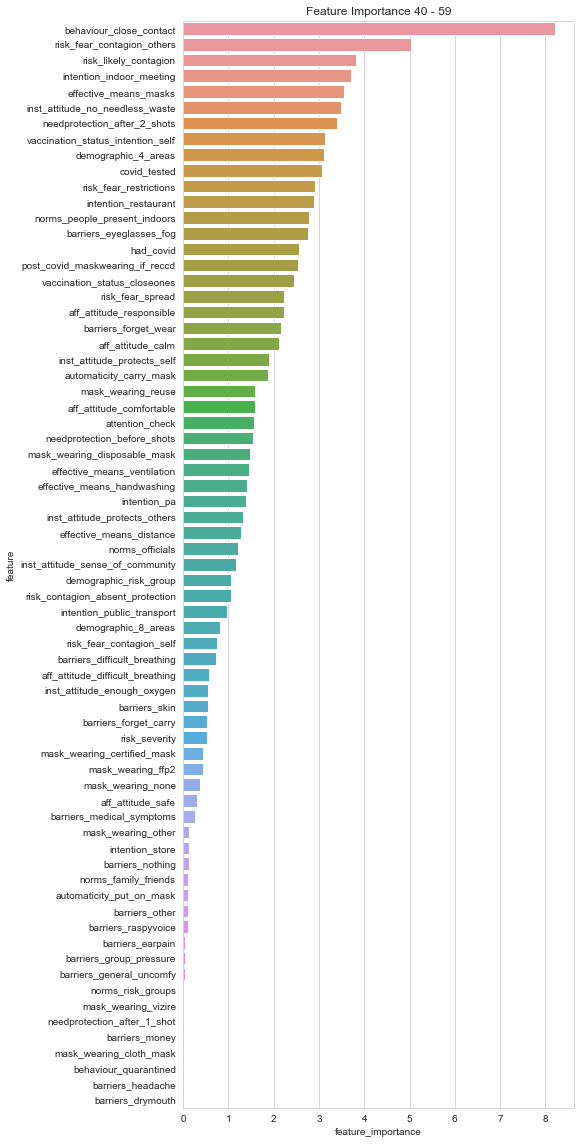

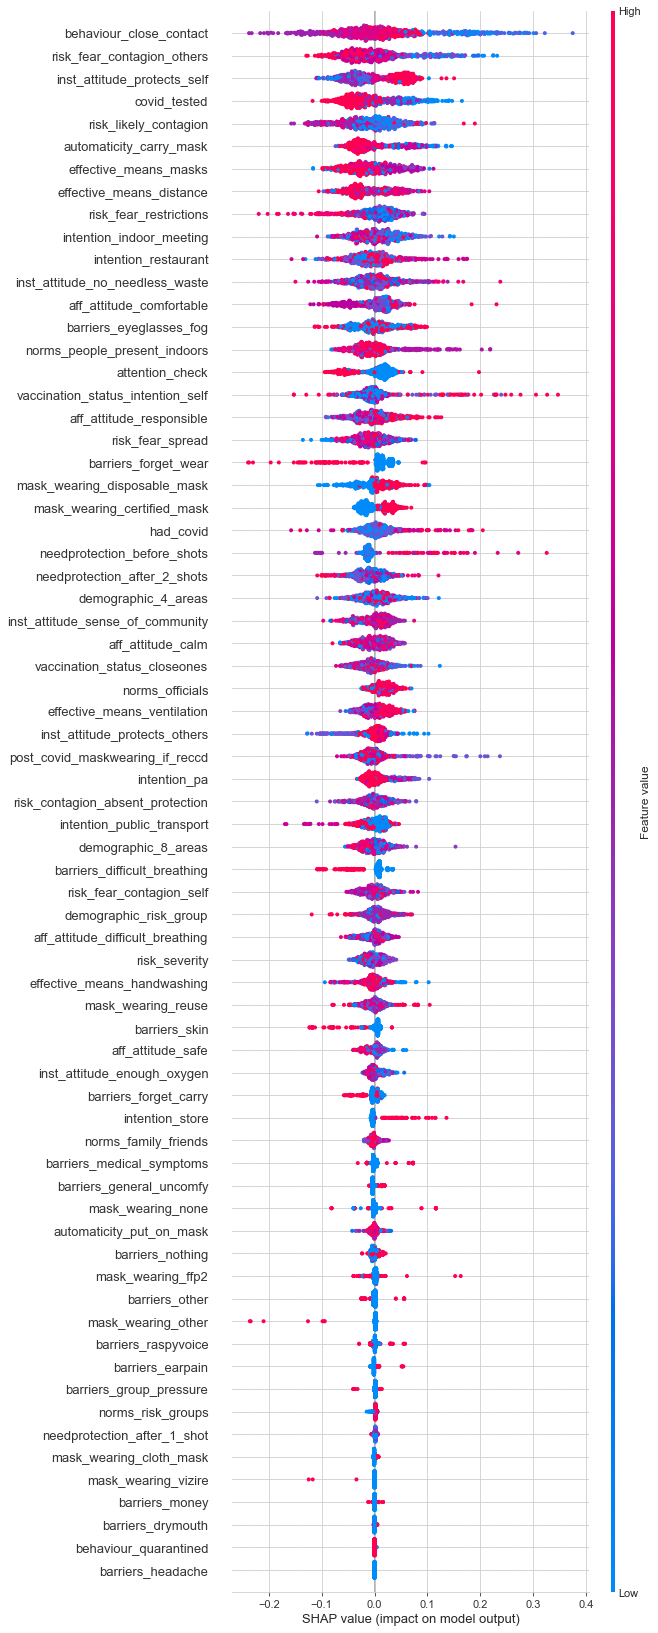

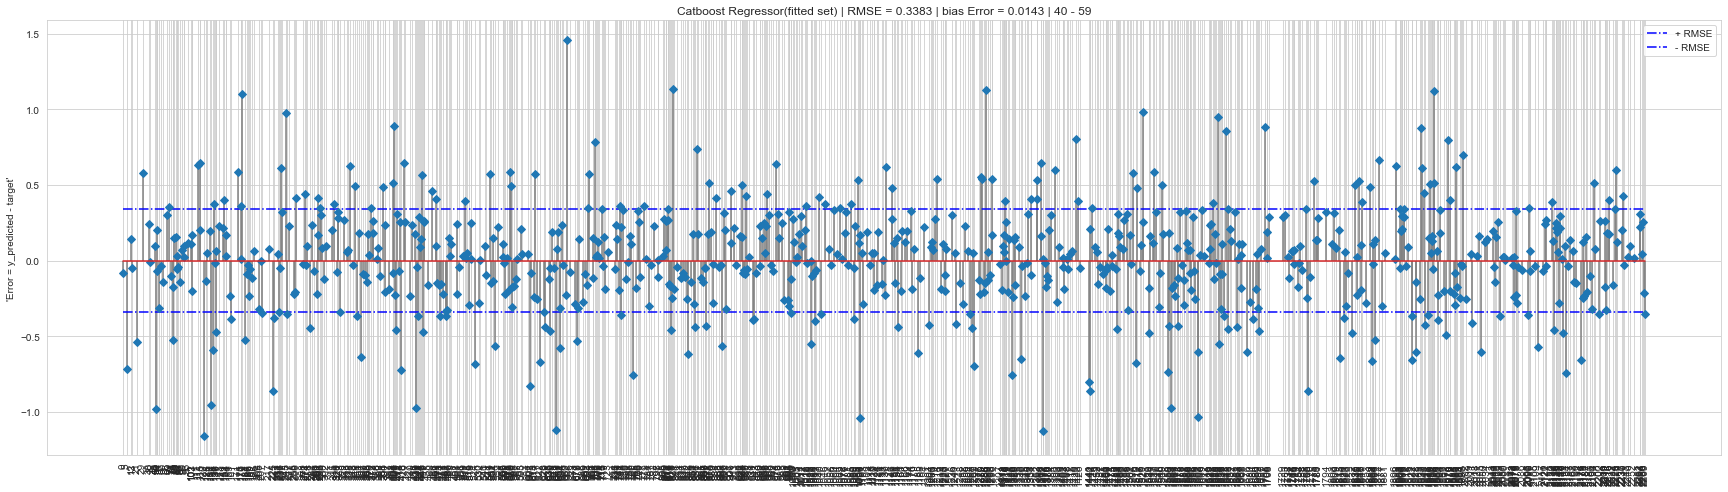

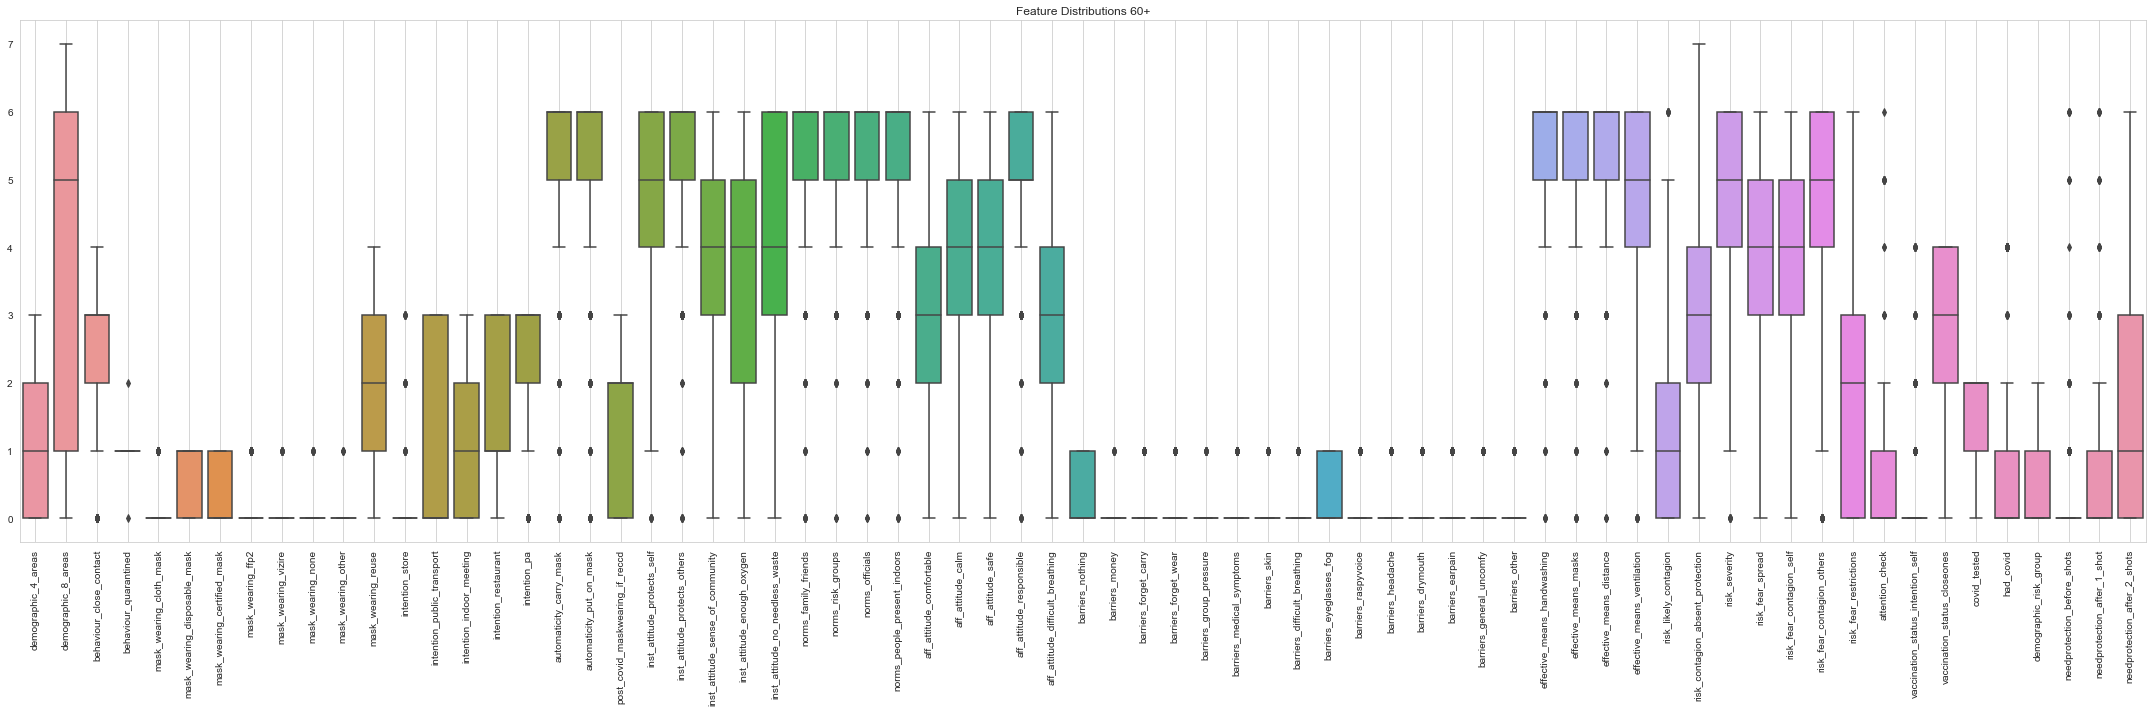

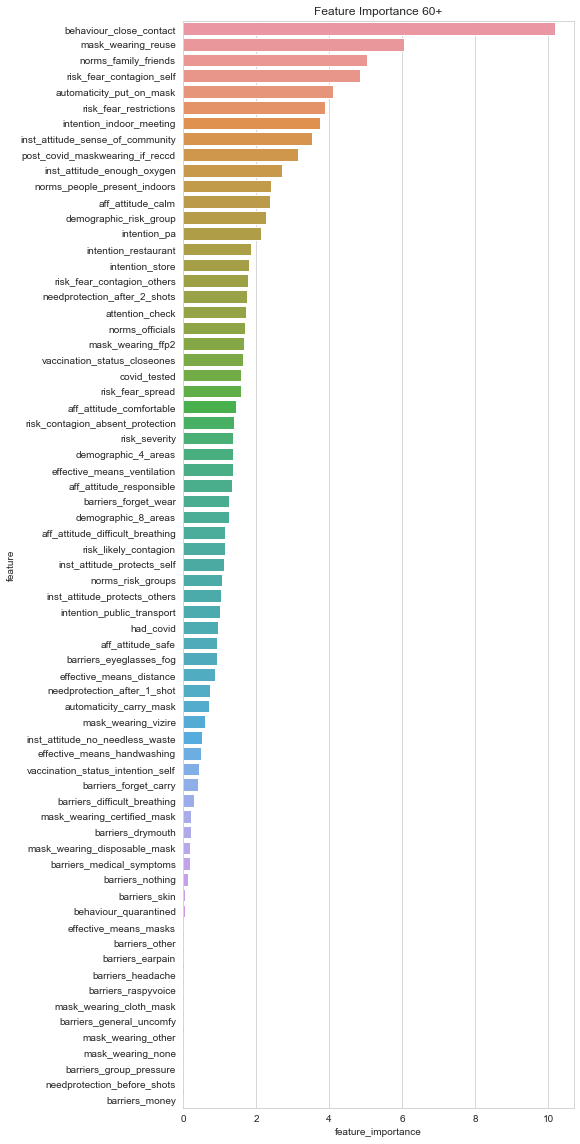

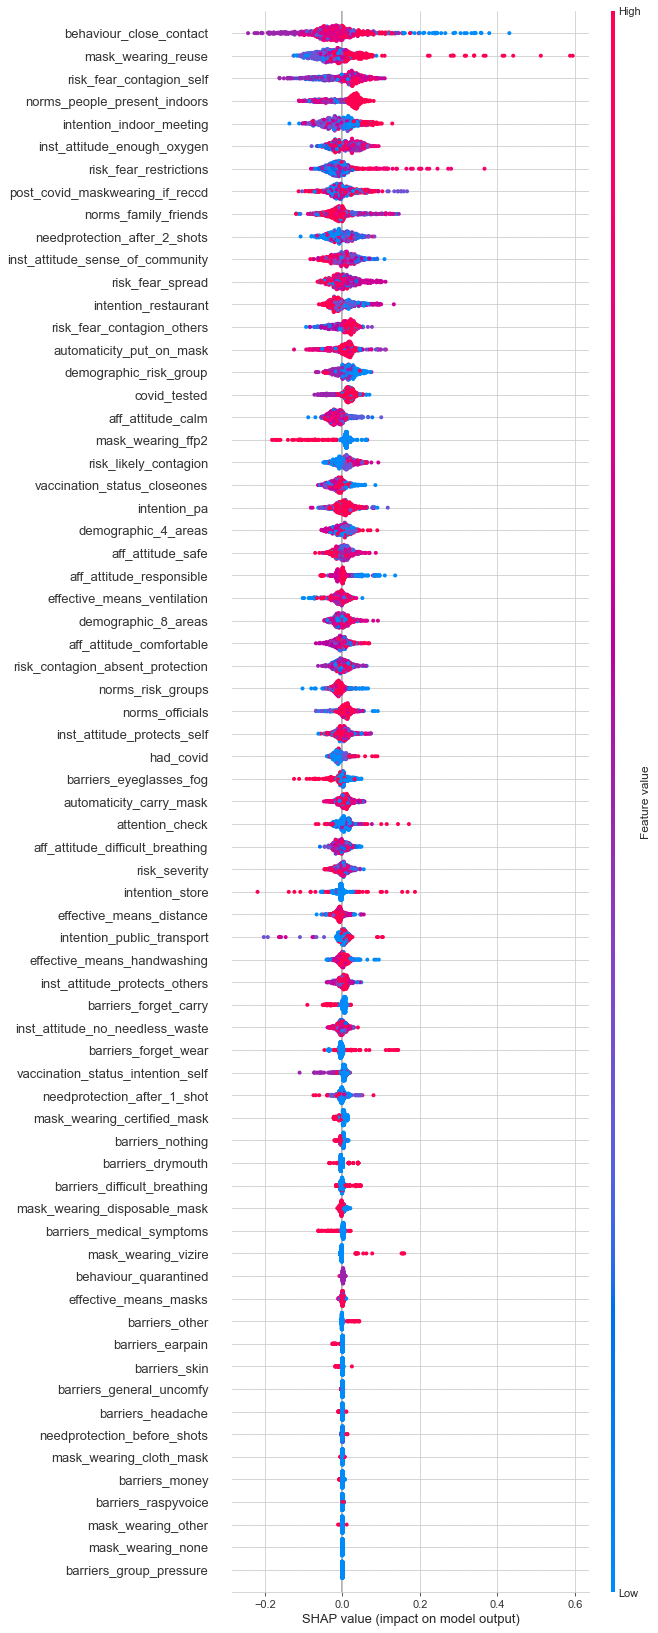

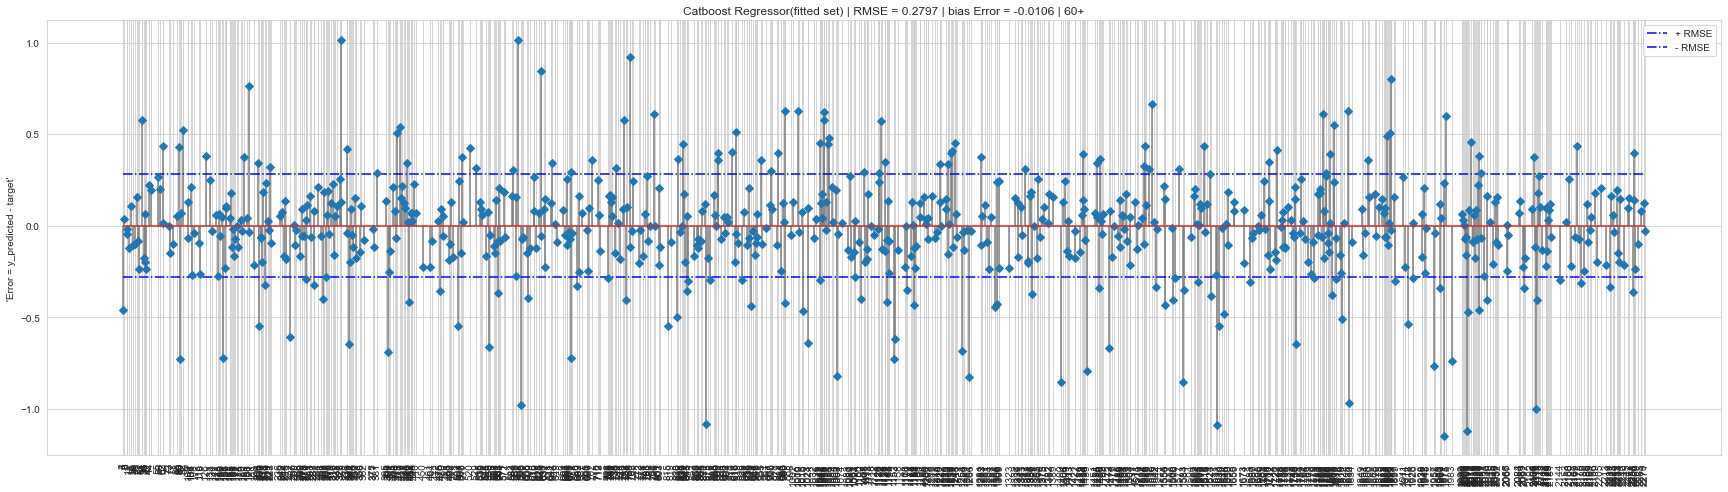

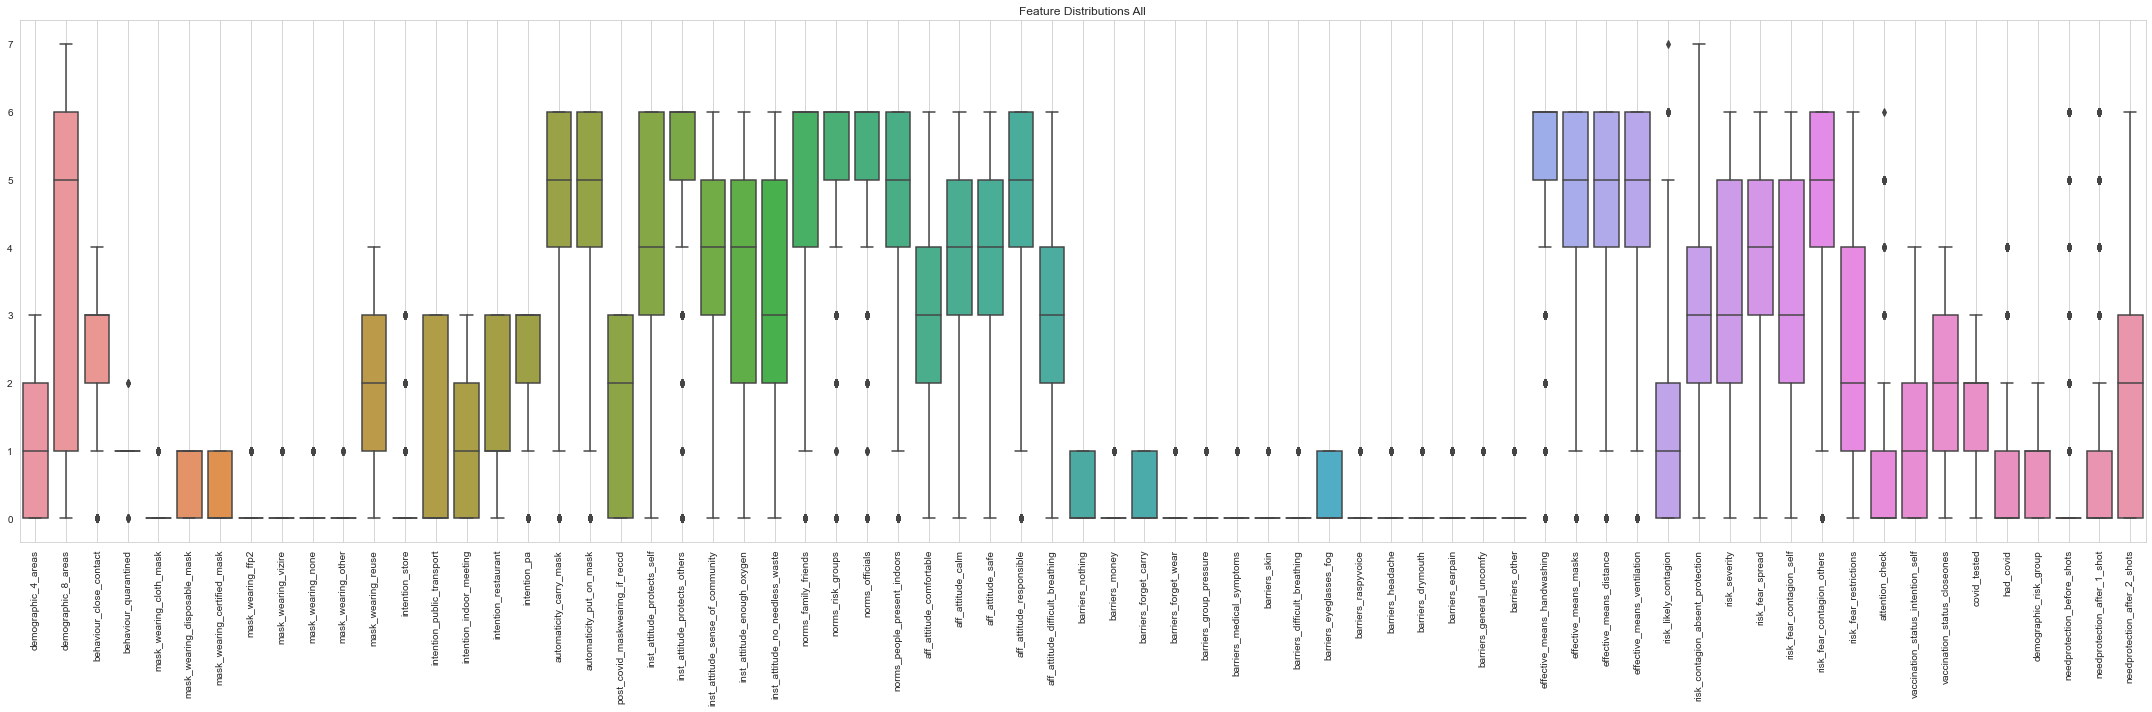

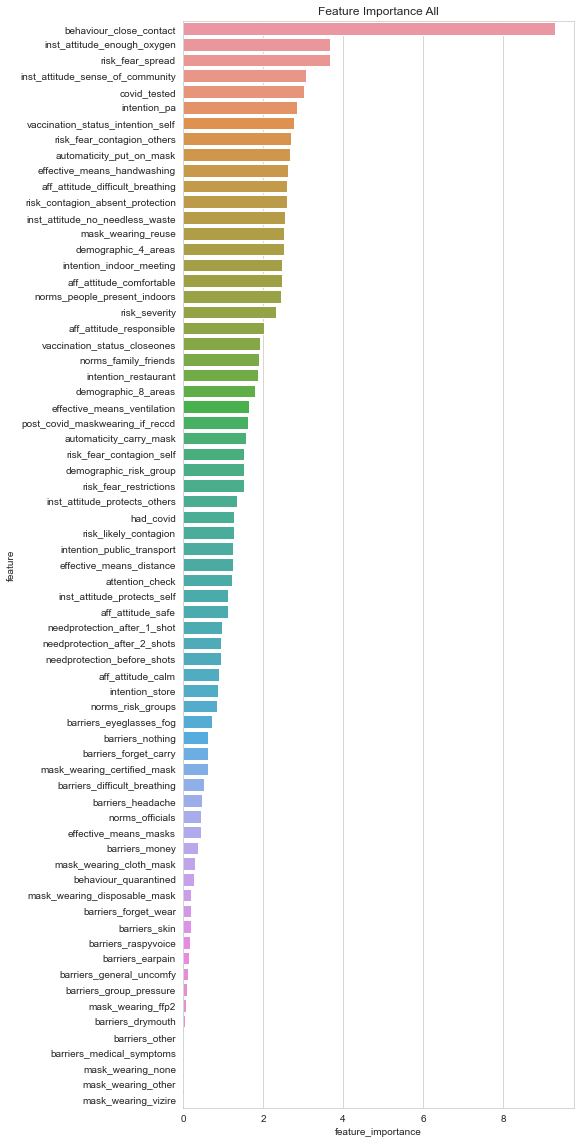

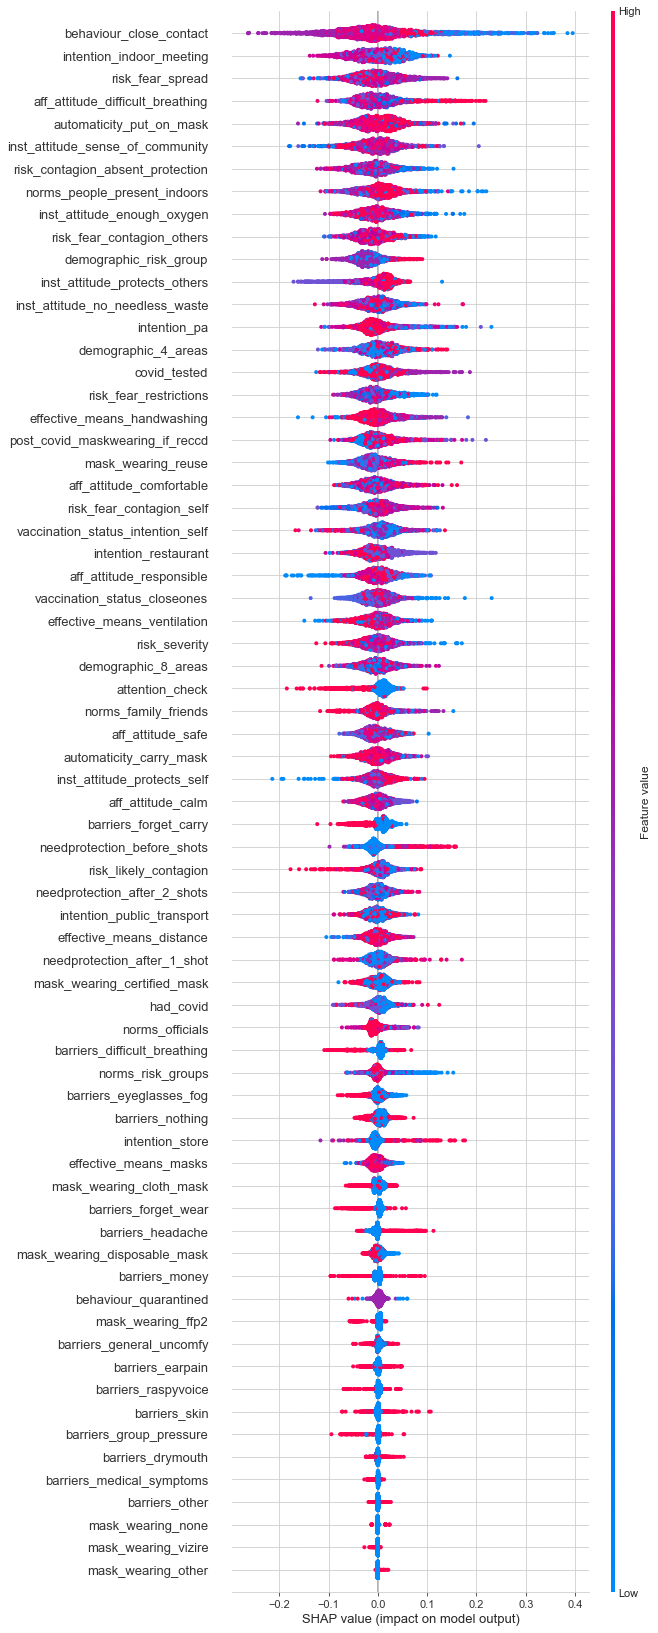

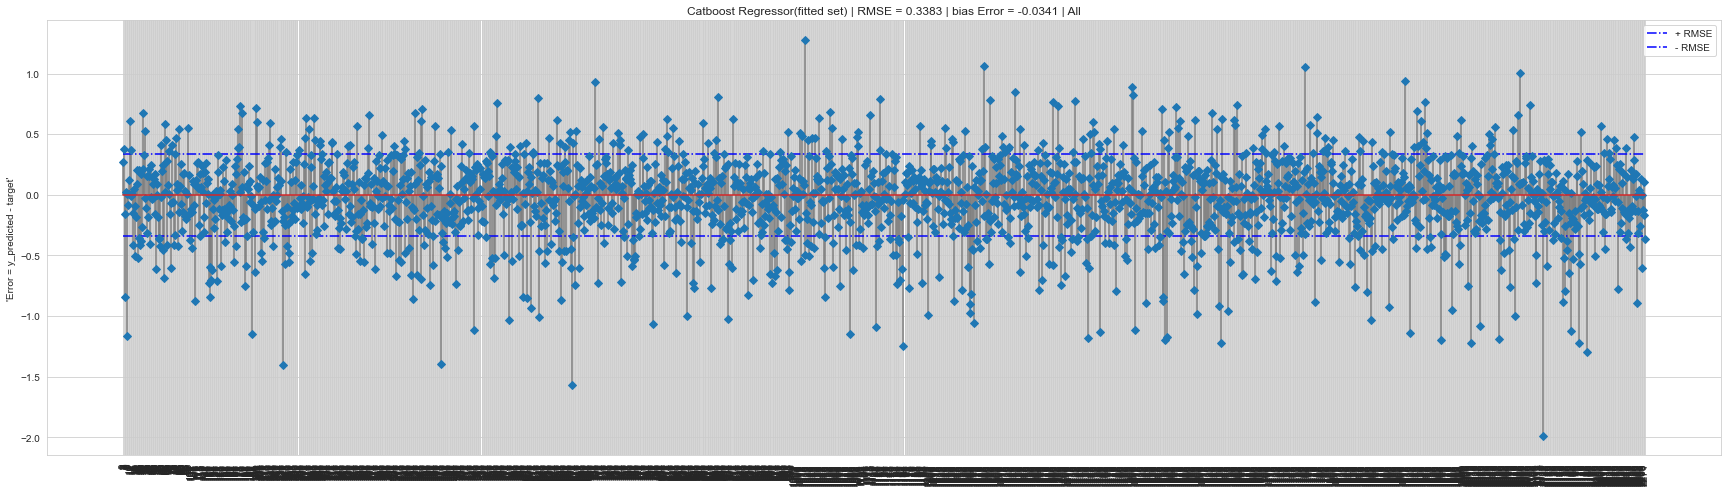

In [40]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

feature_plot_1, gini_plot_1, shap_plot_1, rmse_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

feature_plot_2, gini_plot_2, shap_plot_2, rmse_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="60+"
                                                                                  )

feature_plot_3, gini_plot_3, shap_plot_3, rmse_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="All"
                                                                                  )

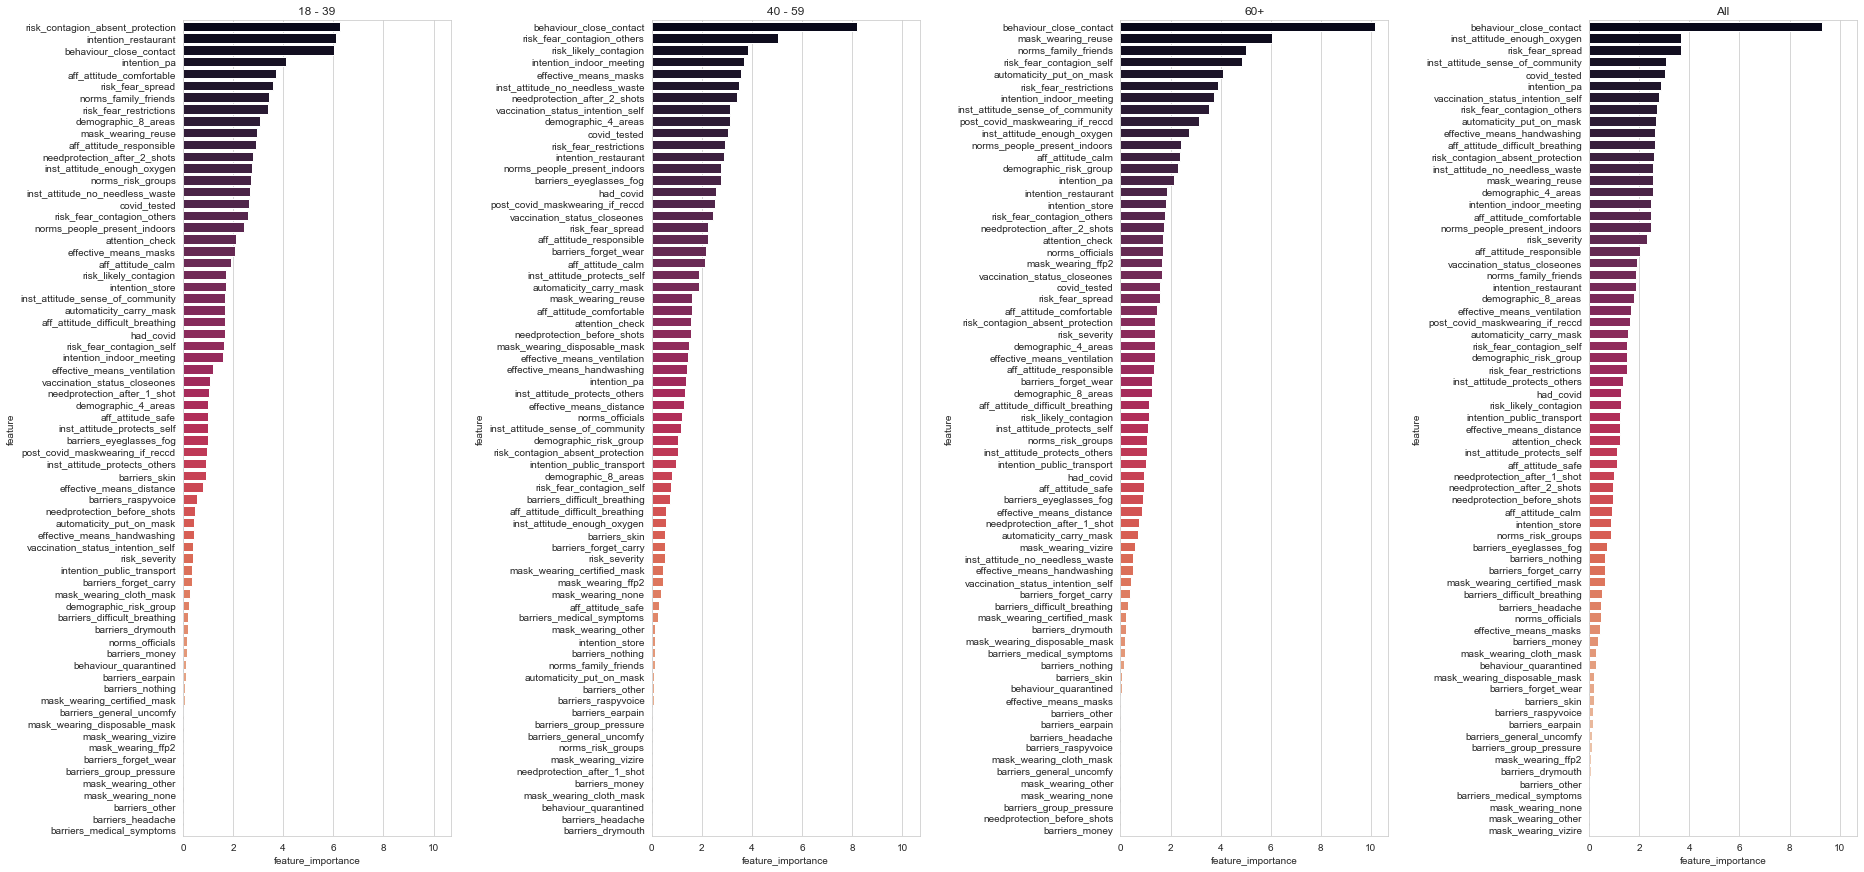

In [41]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [42]:
fig.savefig(f"images/feature_importance_age_groups.png", dpi=400, bbox_inches="tight")

In [43]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

In [44]:
# pd.concat(fi_dfs_list, axis=0).groupby("age_group").head()

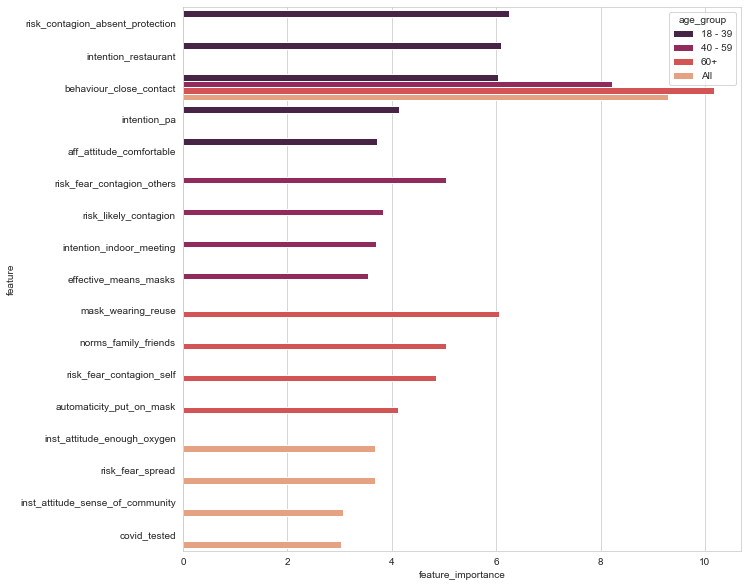

In [45]:
_ = plt.figure(figsize=(10, 10))
_ = sns.barplot(
#     data=pd.concat(fi_dfs_list, axis=0), 
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [46]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [47]:
# fis_df.columns = ['feature_young', 'feature_importance_young', 'feature_middle', 'feature_importance_middle',
#        'feature_old', 'feature_importance_old', 'feature_all', 'feature_importance_all']

In [48]:
fis_df.head(5)

feature  feature_importance age_group  \
0  risk_contagion_absent_protection                6.25   18 - 39   
1              intention_restaurant                6.09   18 - 39   
2           behaviour_close_contact                6.04   18 - 39   
3                      intention_pa                4.13   18 - 39   
4          aff_attitude_comfortable                3.71   18 - 39   

                      feature  feature_importance age_group  \
0     behaviour_close_contact                8.21   40 - 59   
1  risk_fear_contagion_others                5.04   40 - 59   
2       risk_likely_contagion                3.83   40 - 59   
3    intention_indoor_meeting                3.70   40 - 59   
4       effective_means_masks                3.55   40 - 59   

                    feature  feature_importance age_group  \
0   behaviour_close_contact               10.18       60+   
1        mask_wearing_reuse                6.06       60+   
2      norms_family_friends                5.03       60+   
3  risk_fear_contagion_self                4.84       60+   
4  automaticity_put_on_mask                4.11       60+   

                            feature  feature_importance age_group  
0           behaviour_close_contact                9.29       All  
1       inst_attitude_enough_oxygen                3.67       All  
2                  risk_fear_spread                3.67       All  
3  inst_attitude_sense_of_community                3.07       All  
4                      covid_tested                3.02       All

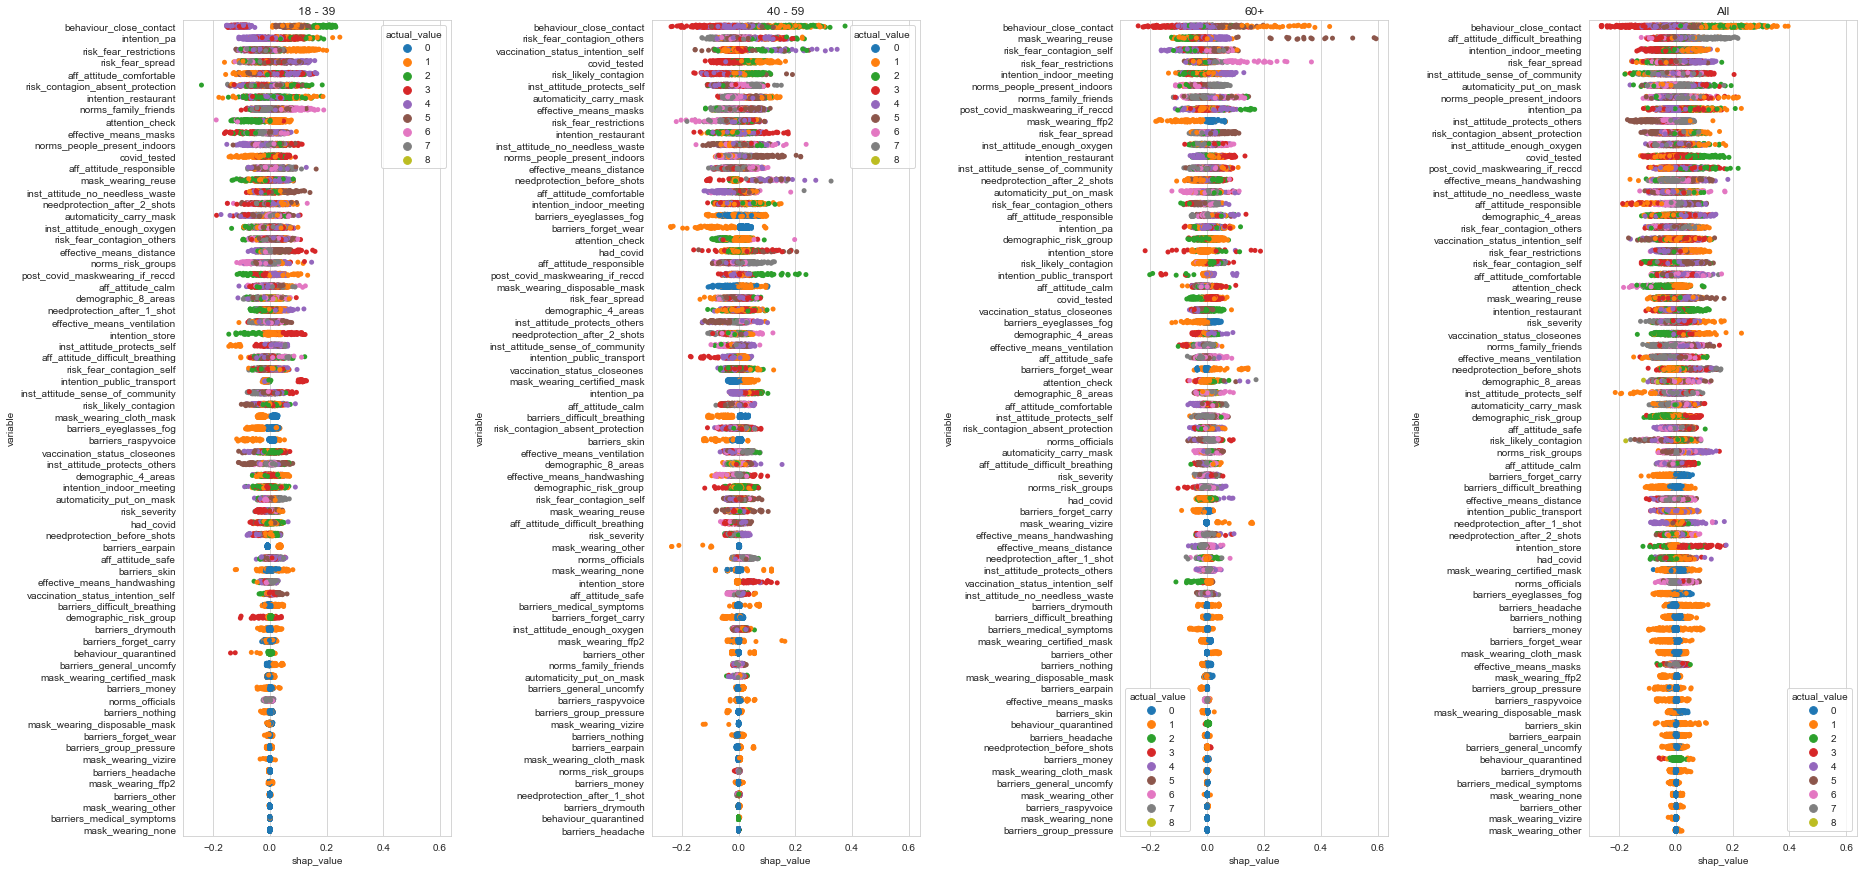

In [49]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
    _ = axs[i].set_title(shap_titles_list[i])
# _ = plt.show()

In [50]:
fig.savefig(f"images/shap_values_all_age_groups.png", dpi=400, bbox_inches="tight")

In [51]:
# shap_plot_3.suptitle("My title")
plot_title = "18 - 39"
shap_plot_0.suptitle(plot_title, y=0.89)
shap_plot_0.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "40 - 59"
shap_plot_1.suptitle(plot_title, y=0.89)
shap_plot_1.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "60+"
shap_plot_2.suptitle(plot_title, y=0.89)
shap_plot_2.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "All"
shap_plot_3.suptitle(plot_title, y=0.89)
shap_plot_3.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")

In [52]:
# dec_bound_plot_0

In [53]:
# clf = CatBoostClassifier(iterations=500,
#                            depth=None,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            verbose=False)

In [54]:
# feature_importance_df_0.head(5).feature.tolist()

In [55]:
# tmp_df = df[df["demographic_age"].isin(['18-29', '30-39'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['40-49', '50-59'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['60+'])].reset_index()
tmp_df = df.reset_index(drop=True)

# X = tmp_df[feature_importance_df_0.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_1.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_2.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_3.head(5).feature.tolist()]

X = tmp_df[features_list[2:]]

# X = tmp_df[df.filter(regex="sdt").columns.tolist()]

y = tmp_df[grouping_var]

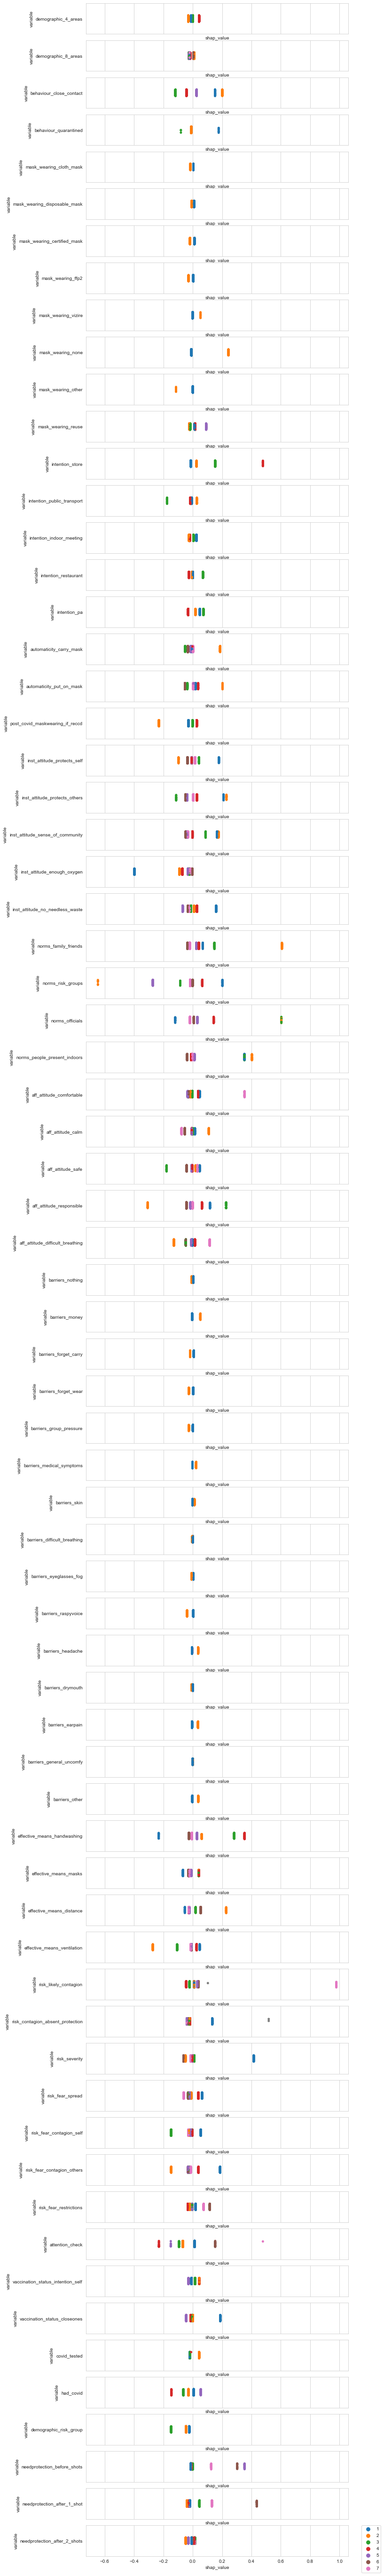

In [56]:
fig, axs = plt.subplots(nrows=X.shape[1],
                 ncols=1,
                 sharex=True,
                 sharey=False,
                       figsize=(10, 100),
#                        gridspec_kw={'wspace': 0.75
#                                    }
                       )

for i in range(0, X.shape[1]):

    feature = X.columns.tolist()[i]
    
    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X[[feature]], y, cat_features=[feature]
                 )

    shap_values = model.get_feature_importance(Pool(X[[feature]], label=y,cat_features=[feature]), type="ShapValues")

    shap_values = shap_values[:,:-1]

    tmp_actual = (X[[feature]]
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=[feature])
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)
    
    if i == X.shape[1]-1:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend_.remove()

In [57]:
_ = fig.savefig(f"images/shap_values_ALL_analysis_seperate_per_feature.png", dpi=400, bbox_inches="tight")

In [58]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
# kfold = KFold(n_splits=50, shuffle=True, random_state=42)
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = model.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns)
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({grouping_var: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])

    corr_df = pg.corr(x=pred_test_df[grouping_var], 
            y=pred_test_df["predict"], 
            tail='two-sided', 
            method='pearson', 
    #         **kwargs
           )
    
    all_cors_df = pd.concat([all_cors_df, 
                             corr_df.assign(fold_number=f"fold_{fold_number}")
                            ])
    
    fold_number += 1

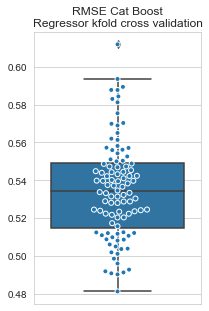

In [59]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [60]:
pd.DataFrame(accuracies_list).describe().T

count      mean       std       min       25%      50%       75%       max
0  100.0  0.535132  0.026257  0.481146  0.514838  0.53415  0.549134  0.611923

In [61]:
# pd.DataFrame(model.predict(X)).head()

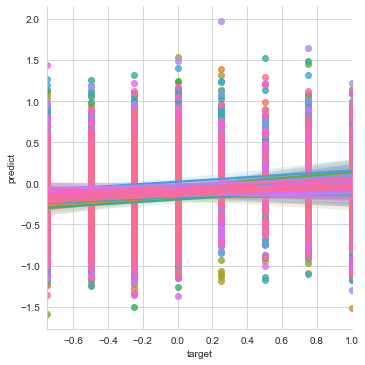

In [62]:
_ = sns.lmplot(data=all_pred_test_df, 
               x=grouping_var, 
               y="predict", 
               hue="fold_number",
              legend=False)

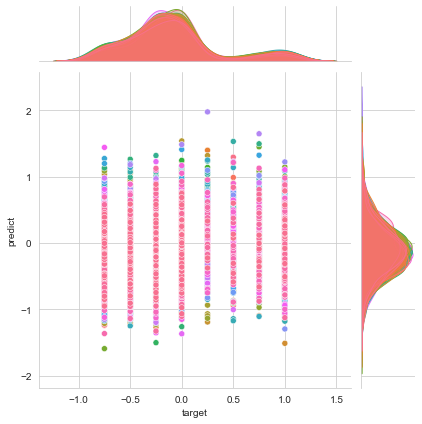

In [63]:
ax = sns.jointplot(data=all_pred_test_df, 
                  x=grouping_var, 
                  y="predict", 
                  hue="fold_number",
#                   kind="reg",
                   legend=False
                 )
# _ = ax._legend.remove()

In [64]:
all_cors_df.describe()

n           r       p-val       power
count  100.000000  100.000000  100.000000  100.000000
mean   226.300000    0.100360    0.243711    0.377971
std      0.460566    0.061614    0.271687    0.261591
min    226.000000   -0.069204    0.000043    0.049991
25%    226.000000    0.055572    0.032549    0.133079
50%    226.000000    0.102651    0.123882    0.337896
75%    227.000000    0.142182    0.403486    0.572641
max    227.000000    0.267915    0.981523    0.984551

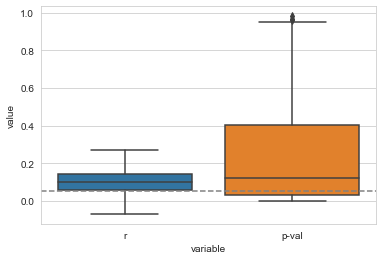

In [65]:
_ = sns.boxplot(data=all_cors_df[["r", "p-val"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [71]:
# summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df, 
#                   feature1=grouping_var, 
#                   feature2="predict",
#                                                        plot=False)

In [70]:
# _ = plt.figure(figsize=(10,5))
# ax = sns.lineplot(data = summary,
#                 x="N",
#                 y="r-value",
# #                 hue="user_id"
#                   color="blue",
#                 )
# ax2 = plt.twinx()
# _ = sns.lineplot(data = summary,
#                 x="N",
#                 y="p-value",
# #                 hue="user_id",
#                  color="orange",
#                  ax=ax2
#                 )
# _ = plt.axhline(0.05, c="gray", ls="--")
# # _ = plt.axhline(0.0, c="gray")

# ax2.spines['left'].set_color("blue")
# ax2.spines['left'].set_linewidth(2)
# ax2.spines['bottom'].set_color("blue")
# ax2.spines['bottom'].set_linewidth(2)
# ax2.spines['right'].set_color("orange")
# ax2.spines['right'].set_linewidth(2)
# ax2.spines['top'].set_color("orange")
# ax2.spines['top'].set_linewidth(2)

# ax.yaxis.set_ticks_position('none') 
# ax2.yaxis.set_ticks_position('none') 

# _ = plt.title("Correlation between real and predicted mask obedience")
# # _ = plt.savefig(f"images/correlation_predict_vs_real.png", dpi=400, format="png")

In [68]:
all_cors_as_N_increases_df = pd.DataFrame()
for fold_number in all_pred_test_df.fold_number.unique().tolist():
    summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df[all_pred_test_df["fold_number"]==fold_number], 
                  feature1=grouping_var, 
                  feature2="predict",
                                                           plot=False)

    all_cors_as_N_increases_df = pd.concat([all_cors_as_N_increases_df, 
                                            summary.assign(fold_number=f"fold_{fold_number}")])

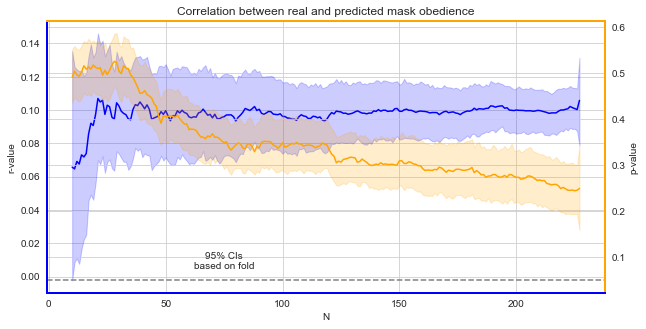

In [72]:
_ = plt.figure(figsize=(10,5))
ax = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="r-value",
#                 hue="user_id"
                  color="blue",
                )
ax2 = plt.twinx()
_ = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="p-value",
#                 hue="user_id",
                 color="orange",
                 ax=ax2
                )
_ = plt.axhline(0.05, c="gray", ls="--")
# _ = plt.axhline(0.0, c="gray")

ax2.spines['left'].set_color("blue")
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_color("blue")
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_color("orange")
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_color("orange")
ax2.spines['top'].set_linewidth(2)

ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 

_ = plt.title("Correlation between real and predicted mask obedience")

_ = plt.annotate(xy=(75, 0.075), text="95% CIs\nbased on fold", ha="center")

# _ = plt.xlim((0, 100))
# _ = plt.ylim((0, 100))

_ = plt.savefig(f"images/correlation_predict_vs_real_CIs_per_fold.png", dpi=400, format="png")